In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [3]:
%run ../common_code.ipynb

In [4]:
data = pd.read_csv("../../datasets/diabetes.csv")
#data["OutcomeB"] = data["Outcome"].replace({"F": 1, "M": 0})
n_features = data.shape[1]-1
n = data.shape[0]
target = "Outcome"
features = data.columns.difference([target]).tolist()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
n

768

In [102]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
#preprocessing


## Using gradient boosting regressor for experiments

In [6]:
model = GradientBoostingClassifier(n_estimators=10)
#model = LogisticRegression()
model.fit(data[features], data[target])

GradientBoostingClassifier(n_estimators=10)

## calculating individual errors

In [7]:
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data[target]+(probs)*(1-data[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,inconf_error
0,6,148,72,35,0,33.6,0.627,50,0.480377
1,1,85,66,29,0,26.6,0.351,31,0.212730
2,8,183,64,0,0,23.3,0.672,32,0.446119
3,1,89,66,23,94,28.1,0.167,21,0.172690
4,0,137,40,35,168,43.1,2.288,33,0.414921


## discretization into gradarions

In [8]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness,inconf_error
0,2,1,1,1,2,0,1,1,1
1,0,0,1,0,0,0,0,1,0
2,0,0,1,1,2,0,1,0,1
3,0,1,1,0,0,0,0,1,0
4,0,2,1,2,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...
763,2,1,2,0,0,1,2,1,1
764,0,1,1,0,1,0,0,1,0
765,0,0,1,0,1,1,1,1,0
766,1,1,1,0,1,0,0,0,2


In [9]:
pipeline_data["cont_features"]

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'inconf_error']

In [10]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
dicval

{'Pregnancies': [0.0, 0.0, 1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 17.0],
 'Glucose': [0.0,
  85.0,
  95.0,
  102.0,
  109.0,
  117.0,
  125.0,
  134.0,
  147.0,
  167.0,
  199.0],
 'BloodPressure': [0.0,
  54.0,
  60.0,
  64.0,
  68.0,
  72.0,
  74.0,
  78.0,
  82.0,
  88.0,
  122.0],
 'SkinThickness': [0.0,
  0.0,
  0.0,
  8.200000000000045,
  18.0,
  23.0,
  27.0,
  31.0,
  35.0,
  40.0,
  99.0],
 'Insulin': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  30.5,
  72.20000000000005,
  106.0,
  150.0,
  210.0,
  846.0],
 'BMI': [0.0,
  23.6,
  25.9,
  28.2,
  30.1,
  32.0,
  33.7,
  35.489999999999995,
  37.8,
  41.5,
  67.1],
 'DiabetesPedigreeFunction': [0.078,
  0.165,
  0.2194,
  0.259,
  0.3028,
  0.3725,
  0.45420000000000005,
  0.5636999999999999,
  0.687,
  0.8786000000000002,
  2.42],
 'Age': [21.0,
  22.0,
  23.0,
  25.0,
  27.0,
  29.0,
  33.0,
  38.0,
  42.60000000000002,
  51.0,
  81.0],
 'inconf_error': [0.15944113352531042,
  0.17136387319610555,
  0.1915407189223643,
  0.211465328

## automatic adjustment of gradations
for features with unfair gradations kmeans split
in general gradations are up to reseacher reasoning

In [11]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [3, 7, 4, 0]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

## rediscretization after the adjustment

In [12]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,inconf_error
0,2,2,1,2,1,1,1,2,1
1,1,0,1,1,1,0,0,1,0
2,2,2,1,0,1,0,1,1,1
3,1,0,1,1,1,1,0,0,0
4,0,1,1,2,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...
763,2,0,2,2,2,1,0,2,1
764,1,1,1,1,1,1,0,1,0
765,2,1,1,1,2,0,0,1,0
766,1,1,1,0,1,1,0,2,2


In [13]:
disc_data['inconf_error'].value_counts()

inconf_error
0    407
1    243
2    118
Name: count, dtype: int64

In [14]:
current_error = data_errors["inconf_error"].sum()/n
current_error

0.35125423193517996

In [15]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [16]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'Pregnancies': 3,
 'Glucose': 3,
 'BloodPressure': 3,
 'SkinThickness': 3,
 'Insulin': 2,
 'BMI': 3,
 'DiabetesPedigreeFunction': 3,
 'Age': 3,
 'inconf_error': 3}

In [17]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]

In [18]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [19]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,DiabetesPedigreeFunction,Discrete,disc,[],[]
1,Insulin,Discrete,disc,[DiabetesPedigreeFunction],[disc]
2,SkinThickness,Discrete,disc,[Insulin],[disc]
3,BMI,Discrete,disc,[SkinThickness],[disc]
4,BloodPressure,Discrete,disc,[SkinThickness],[disc]
5,Age,Discrete,disc,[SkinThickness],[disc]
6,Pregnancies,Discrete,disc,[Age],[disc]
7,Glucose,Discrete,disc,"[Insulin, Age]","[disc, disc]"
8,inconf_error,Discrete,disc,"[Glucose, BMI]","[disc, disc]"


In [20]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [21]:
bn.distributions

{'DiabetesPedigreeFunction': {'cprob': [0.6171875,
   0.3216145833333333,
   0.061197916666666664],
  'vals': ['0', '1', '2']},
 'Insulin': {'cprob': {"['1']": [0.611336032388664, 0.38866396761133604],
   "['0']": [0.7573839662447257, 0.24261603375527427],
   "['2']": [0.5531914893617021, 0.44680851063829785]},
  'vals': ['1', '2']},
 'SkinThickness': {'cprob': {"['1']": [0.4253731343283582,
    0.35261194029850745,
    0.22201492537313433],
   "['2']": [0.01293103448275862, 0.47413793103448276, 0.5129310344827587]},
  'vals': ['0', '1', '2']},
 'BMI': {'cprob': {"['2']": [0.046218487394957986,
    0.47058823529411764,
    0.4831932773109244],
   "['1']": [0.35451505016722407, 0.5852842809364549, 0.06020066889632107],
   "['0']": [0.354978354978355, 0.45454545454545453, 0.19047619047619047]},
  'vals': ['0', '1', '2']},
 'BloodPressure': {'cprob': {"['2']": [0.008403361344537815,
    0.5084033613445378,
    0.4831932773109244],
   "['1']": [0.010033444816053512, 0.7090301003344481, 0.2

## applying YODO

In [22]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

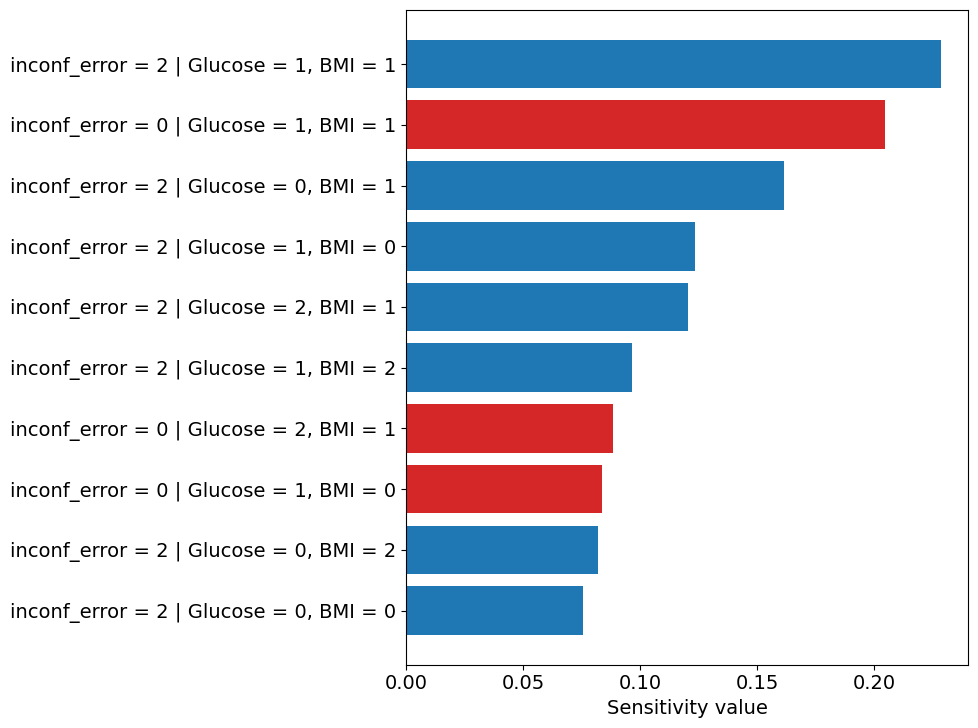

In [23]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии средних значений Glucose и BMI

In [24]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score

In [25]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

## applying SHAP

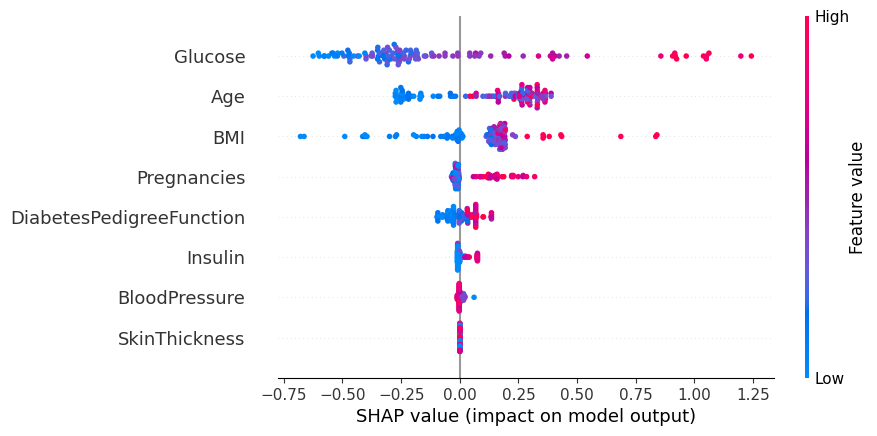

In [26]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['inconf_error']==2][features])
shap.plots.beeswarm(shap_values)

трактование: больше всего на предскзаания для наблюдений с высокой ошибкой влияет glucose и age, большее влияние от высоких значений (влияние на результат, дающий высокую ошибку)

## applying our approarch

In [27]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,Pregnancies_0,Pregnancies_1,Pregnancies_2,Glucose_0,Glucose_1,Glucose_2,BloodPressure_0,BloodPressure_1,BloodPressure_2,SkinThickness_0,...,BMI_2,DiabetesPedigreeFunction_0,DiabetesPedigreeFunction_1,DiabetesPedigreeFunction_2,Age_0,Age_1,Age_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
2,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
3,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
764,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
765,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
766,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,1


In [28]:
from itertools import product

In [29]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-24 23:08:36,130 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,132 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,133 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,134 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,135 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,136 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,137 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,138 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,139 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-24 23:08:36,141 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [30]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,Pregnancies_2,Discrete,disc,[],[]
1,DiabetesPedigreeFunction_2,Discrete,disc,[],[]
2,Age_2,Discrete,disc,[Pregnancies_2],[disc]
3,Age_0,Discrete,disc,[Pregnancies_2],[disc]
4,BMI_1,Discrete,disc,[Age_0],[disc]
5,SkinThickness_1,Discrete,disc,"[BMI_1, Age_0]","[disc, disc]"
6,BloodPressure_1,Discrete,disc,"[SkinThickness_1, Age_2]","[disc, disc]"
7,Pregnancies_1,Discrete,disc,"[SkinThickness_1, Age_2]","[disc, disc]"
8,BMI_2,Discrete,disc,"[BloodPressure_1, SkinThickness_1]","[disc, disc]"
9,Age_1,Discrete,disc,[Pregnancies_1],[disc]


In [31]:
info = gbn.get_info()
info.iloc[25, 3]

['Glucose_1', 'BMI_0']

In [32]:
gbn.custom_mapper

In [ ]:
gbn.plot("diab_classif.html")

In [34]:
n_states_map

{'Pregnancies': 3,
 'Glucose': 3,
 'BloodPressure': 3,
 'SkinThickness': 3,
 'Insulin': 2,
 'BMI': 3,
 'DiabetesPedigreeFunction': 3,
 'Age': 3,
 'inconf_error': 3}

In [35]:
sorted(disc_data_encoded.columns)

['Age_0',
 'Age_1',
 'Age_2',
 'BMI_0',
 'BMI_1',
 'BMI_2',
 'BloodPressure_0',
 'BloodPressure_1',
 'BloodPressure_2',
 'DiabetesPedigreeFunction_0',
 'DiabetesPedigreeFunction_1',
 'DiabetesPedigreeFunction_2',
 'Glucose_0',
 'Glucose_1',
 'Glucose_2',
 'Insulin_1',
 'Insulin_2',
 'Pregnancies_0',
 'Pregnancies_1',
 'Pregnancies_2',
 'SkinThickness_0',
 'SkinThickness_1',
 'SkinThickness_2',
 'inconf_error_0',
 'inconf_error_1',
 'inconf_error_2']

In [36]:
dfeat = ["Glucose", "BMI"]

dcat = [1, 1]

dfeatshap = ["Glucose", "Age"]
dcatshap = [2, 2]

dfeatbn = ["Glucose", "BMI"]
dcatbn = [1, 0]


d_dict={
    'yodo': [dfeat, dcat],
    'bn': [dfeatbn, dcatbn],
    'shap': [dfeatshap, dcatshap]
}

bn = n


In [37]:
data.shape, n

((768, 9), 768)

## run 1: alpha=0.8

In [38]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.8, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [01:25<00:00,  2.91it/s]


In [39]:
stats_res['avg_n_dropped']

{'yodo': 151.808, 'bn': 119.168, 'shap': 99.164, 'init': -1, 'random': -1}

In [40]:
{k: v/n for k, v in stats_res['avg_n_dropped'].items()}

{'yodo': 0.19766666666666666,
 'bn': 0.15516666666666667,
 'shap': 0.12911979166666668,
 'init': -0.0013020833333333333,
 'random': -0.0013020833333333333}

In [41]:
def plot_scores(metrics, graph_label, k):
    avg_metric = {}
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        avg_metric[names_mapping[name]] = sum(metrics[name][k])/len(metrics[name][k])

    plt.legend()
    plt.xlabel(graph_label)
    return avg_metric

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

In [42]:
def extended_experiments_output(stats_dictionary, metrics_labels_list):
    tbl_scores = pd.DataFrame(columns=['method', 'metric', 'value'])
    i=0
    for k, label in enumerate(metrics_labels_list):
        plt.figure()
        avg_stats = plot_scores(stats_dictionary, label, k)
        for key, val in avg_stats.items():
            tbl_scores.loc[i, :] = [key, label, val]
            i+=1
    return pd.pivot(tbl_scores, index='metric', columns='method')


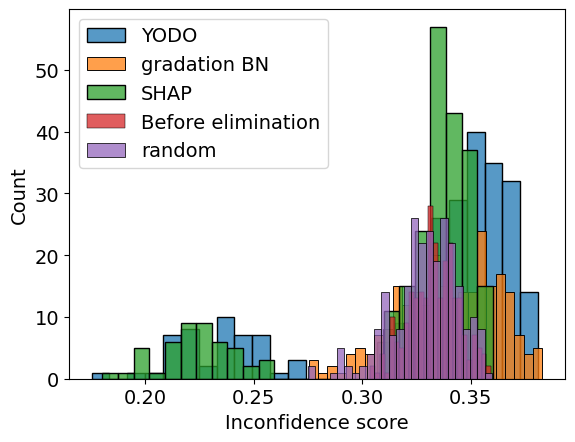

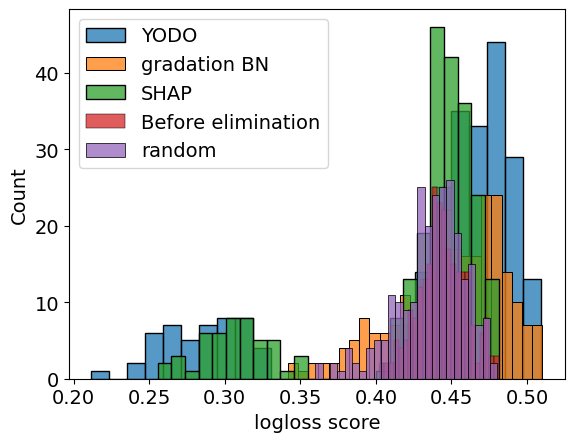

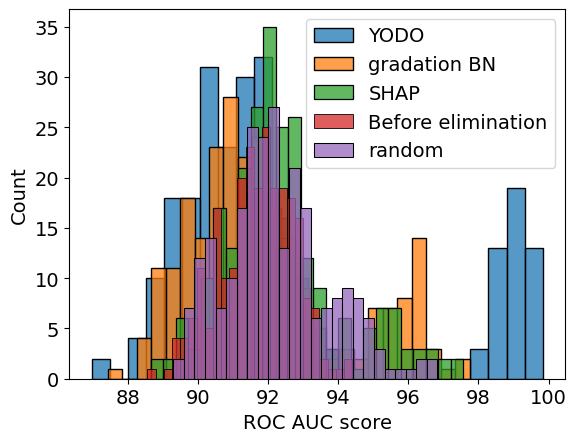

In [43]:
res_train_tbl = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [44]:
res_train_tbl

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.333248    0.31577   0.328264     0.339299   
ROC AUC score                91.66831  92.360179  92.445077    91.909573   
logloss score                0.443823   0.420996   0.431743     0.448793   

                               
method                 random  
metric                         
Inconfidence score   0.328897  
ROC AUC score       92.247959  
logloss score         0.43661

In [45]:
print(res_train_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.333248 & 0.315770 & 0.328264 & 0.339299 & 0.328897 \\
ROC AUC score & 91.668310 & 92.360179 & 92.445077 & 91.909573 & 92.247959 \\
logloss score & 0.443823 & 0.420996 & 0.431743 & 0.448793 & 0.436610 \\
\bottomrule
\end{tabular}



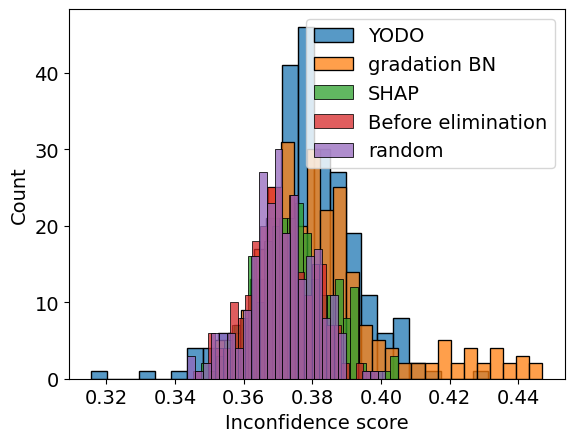

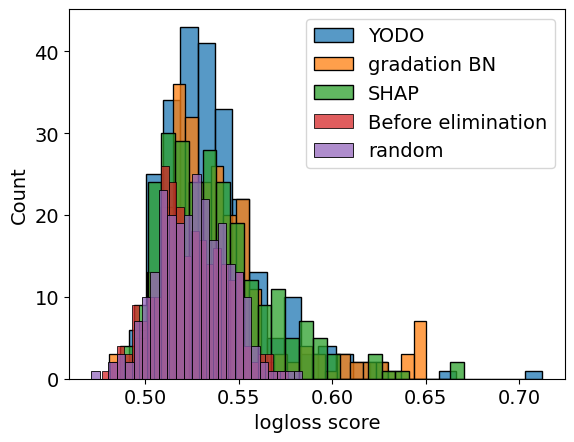

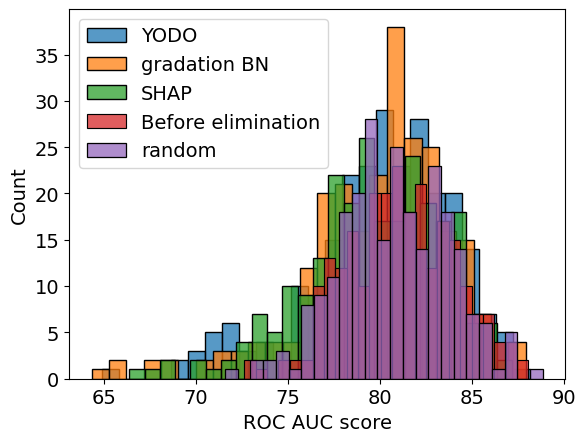

In [46]:
res_test_tbl = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [47]:
res_test_tbl

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.370862   0.374748   0.378814     0.383487   
ROC AUC score               81.053803  79.601313  80.041242    79.826531   
logloss score                0.524095   0.537313   0.536638     0.539786   

                               
method                 random  
metric                         
Inconfidence score   0.371017  
ROC AUC score       80.750472  
logloss score        0.526173

In [48]:
print(res_test_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.370862 & 0.374748 & 0.378814 & 0.383487 & 0.371017 \\
ROC AUC score & 81.053803 & 79.601313 & 80.041242 & 79.826531 & 80.750472 \\
logloss score & 0.524095 & 0.537313 & 0.536638 & 0.539786 & 0.526173 \\
\bottomrule
\end{tabular}



In [49]:
def avg_prcnt_change(stats, name1, name2, metric_num, direction=1):
    cnt = len(stats[name1][0])
    return direction*sum((a-b)/b for a, b in zip(stats[name1][metric_num], stats[name2][metric_num]))/cnt*100

In [50]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1) # ['Inconfidence score', 'logloss score', 'ROC AUC score']

-3.413168942475996

In [51]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)

-2.9996455136883404

In [52]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)

-1.501760559126273

In [53]:
from scipy.stats import ttest_rel

In [54]:
ttest_rel(stats_res['metrics']['bn'][0], stats_res['metrics']['init'][0]) #['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=5.071934447434527, pvalue=7.698074095905138e-07, df=249)

In [55]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=11.502372031966734, pvalue=7.735874852503173e-25, df=249)

In [56]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=8.672752077354778, pvalue=5.532723034888455e-16, df=249)

In [57]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=-6.474509075776472, pvalue=5.029130920885656e-10, df=249)

## Run 2: alpha=0.85

In [96]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.85, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.35)

100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


In [97]:
stats_res['avg_n_dropped']

{'yodo': 167.264, 'bn': 128.752, 'shap': 106.42, 'init': -1, 'random': -1}

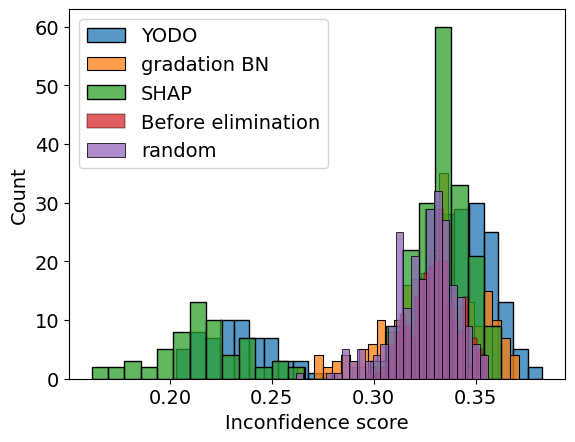

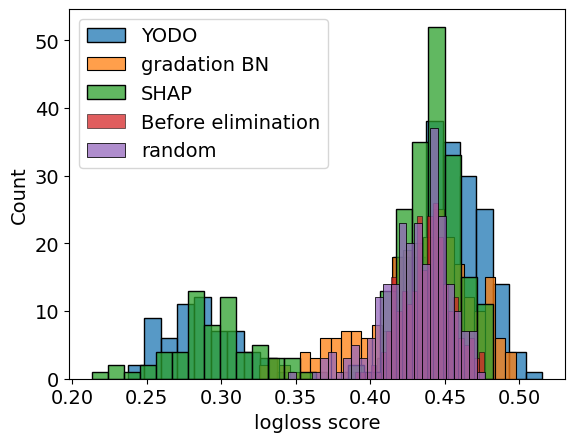

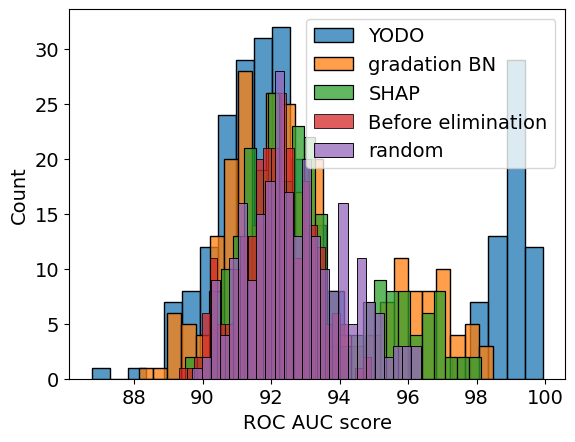

In [98]:
res_train_tbl_1 = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [99]:
res_train_tbl_1

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.329425    0.30387   0.314693     0.328213   
ROC AUC score                92.12795  93.061774  93.484003    92.918219   
logloss score                0.437932    0.40491   0.411676      0.43182   

                               
method                 random  
metric                         
Inconfidence score   0.324553  
ROC AUC score       92.739575  
logloss score        0.429956

In [100]:
print(res_train_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.329425 & 0.303870 & 0.314693 & 0.328213 & 0.324553 \\
ROC AUC score & 92.127950 & 93.061774 & 93.484003 & 92.918219 & 92.739575 \\
logloss score & 0.437932 & 0.404910 & 0.411676 & 0.431820 & 0.429956 \\
\bottomrule
\end{tabular}



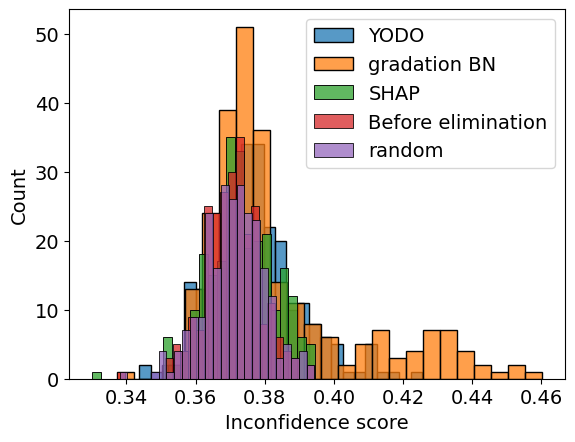

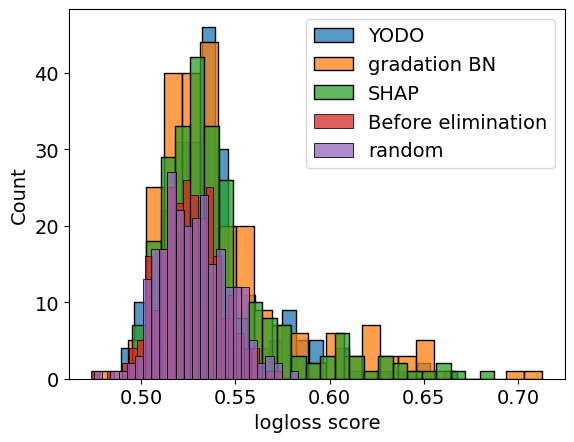

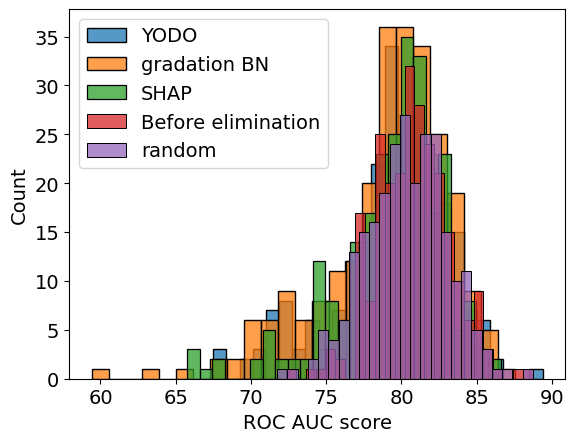

In [101]:
res_test_tbl_1 = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [102]:
res_test_tbl_1

value                                    \
method             Before elimination      SHAP       YODO gradation BN   
metric                                                                    
Inconfidence score           0.370749  0.373254   0.377443     0.383951   
ROC AUC score               80.745106   79.2191  79.345909    78.975903   
logloss score                 0.52576  0.541714   0.538774     0.544571   

                               
method                 random  
metric                         
Inconfidence score   0.371076  
ROC AUC score       80.305544  
logloss score        0.528346

In [103]:
print(res_test_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.370749 & 0.373254 & 0.377443 & 0.383951 & 0.371076 \\
ROC AUC score & 80.745106 & 79.219100 & 79.345909 & 78.975903 & 80.305544 \\
logloss score & 0.525760 & 0.541714 & 0.538774 & 0.544571 & 0.528346 \\
\bottomrule
\end{tabular}



In [104]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-3.555259314842038

In [105]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-3.5793057817540745

In [106]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-2.1798767467196543

In [107]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=10.196311938505469, pvalue=1.2561452536584501e-20, df=249)

In [108]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=8.435985662704688, pvalue=2.7022644305458032e-15, df=249)

In [109]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])

TtestResult(statistic=-7.448721639981035, pvalue=1.5445250067438182e-12, df=249)

## Run 3: alpha=0.75

In [110]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.75, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.35)

100%|██████████| 250/250 [01:11<00:00,  3.49it/s]


In [111]:
stats_res['avg_n_dropped']

{'yodo': 128.576, 'bn': 108.4, 'shap': 92.34, 'init': -1, 'random': -1}

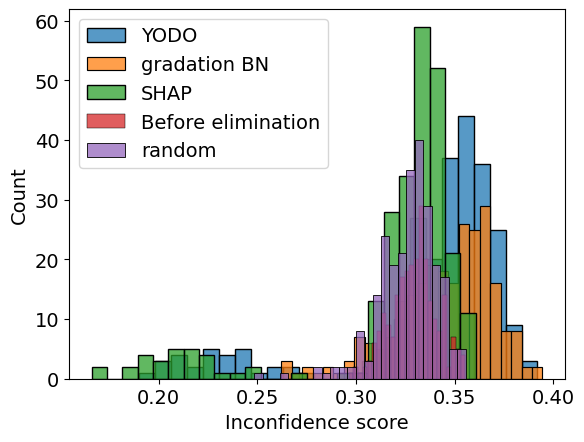

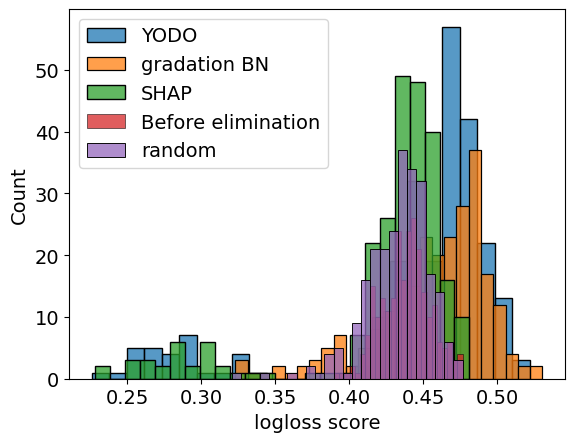

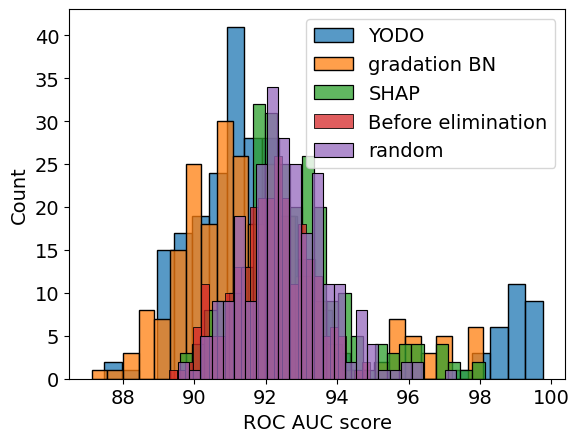

In [112]:
res_train_tbl_2 = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [113]:
res_train_tbl_2

value                                    \
method             Before elimination      SHAP       YODO gradation BN   
metric                                                                    
Inconfidence score           0.329425  0.318637   0.336676     0.344373   
ROC AUC score                92.12795  92.78178  92.234965    91.743505   
logloss score                0.437932  0.422628   0.443607     0.455735   

                               
method                 random  
metric                         
Inconfidence score   0.326242  
ROC AUC score       92.588575  
logloss score        0.432525

In [114]:
print(res_train_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.329425 & 0.318637 & 0.336676 & 0.344373 & 0.326242 \\
ROC AUC score & 92.127950 & 92.781780 & 92.234965 & 91.743505 & 92.588575 \\
logloss score & 0.437932 & 0.422628 & 0.443607 & 0.455735 & 0.432525 \\
\bottomrule
\end{tabular}



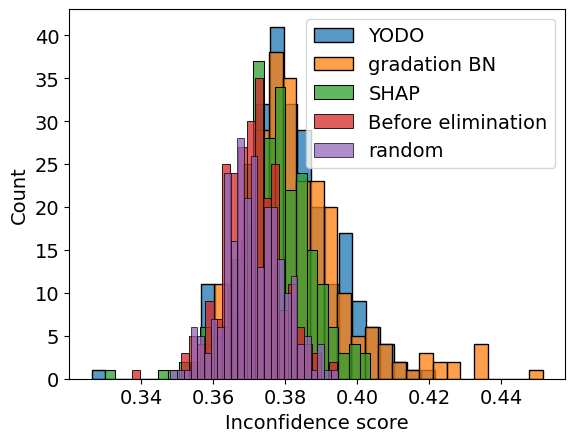

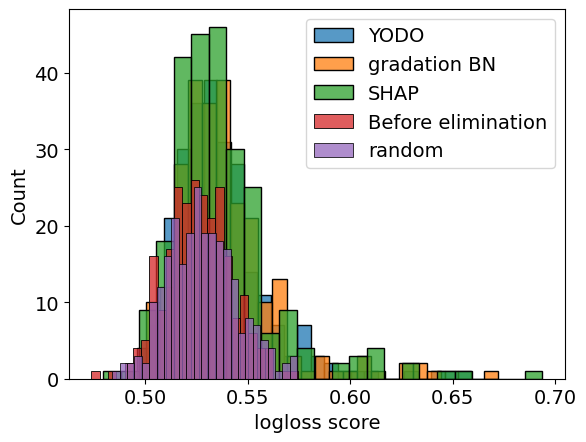

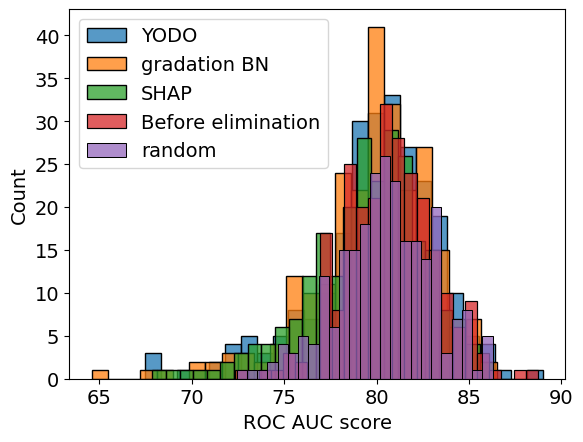

In [115]:
res_test_tbl_2 = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [116]:
res_test_tbl_2

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.370749    0.37682   0.381539     0.383763   
ROC AUC score               80.745106  79.484304  79.896584    79.673228   
logloss score                 0.52576   0.537536   0.537459     0.538898   

                               
method                 random  
metric                         
Inconfidence score   0.371293  
ROC AUC score       80.425799  
logloss score        0.527676

In [117]:
print(res_test_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.370749 & 0.376820 & 0.381539 & 0.383763 & 0.371293 \\
ROC AUC score & 80.745106 & 79.484304 & 79.896584 & 79.673228 & 80.425799 \\
logloss score & 0.525760 & 0.537536 & 0.537459 & 0.538898 & 0.527676 \\
\bottomrule
\end{tabular}



In [118]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-3.5219028157902157

In [119]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-2.5145513428322586

In [120]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-1.317404806658746

In [121]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=14.970007097874111, pvalue=1.4414746223413242e-36, df=249)

In [122]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=9.561196231651964, pvalue=1.1907153276614456e-18, df=249)

In [123]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])

TtestResult(statistic=-6.7168839212574545, pvalue=1.251894843240172e-10, df=249)